In [606]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import skimage

In [178]:
N_PTS = 50

In [591]:
def tangle(points, weights=0.01, steps=1, normalize=True):
    for s in range(steps):
        diff = np.diff(points, axis=0)
        current_length = np.linalg.norm(diff, axis=-1)
        #target_length = np.mean(current_length) * 1.01
        #length_error = current_length - target_length
        curve = np.diff(diff, axis=0) * 0.1
        curve_right = curve - (np.sum(curve * diff[1:], axis=-1) / current_length[1:])[:, None] * diff[1:]
        curve_left = curve - (np.sum(curve * diff[:-1], axis=-1) / current_length[:-1])[:, None] * diff[:-1]
        sqr_dist = np.sum(diff * diff, axis=-1, keepdims=True)
        diff2 = points[2:] - points[:-2]
        sqr_dist2 = np.sum(diff2 * diff2, axis=-1, keepdims=True)
        if normalize:
            sqr_dist /= np.mean(sqr_dist)
            sqr_dist2 /= np.mean(sqr_dist2)
        diff2 /= sqr_dist2

        # Adjust length
        force = np.zeros_like(points)
        #length_force = length_error[:, None] * diff / current_length[:, None]
        force[:len(diff)] = diff #-length_force
        force[1:] -= diff #length_force

        # Repel from points 2 away
        # force[:len(diff2)] -= diff2
        # force[2:] += diff2

        # Straighten bends
        force[:len(curve)] -= curve_left
        force[2:] -= curve_right

        # force[:len(diff) - 1] -= diff1[1:]
        # force[2:] += diff1[:-1]

        # force *= 0.5
        
        points = points + weights * force
    return points

def tangle_2(points, weights=0.0001, steps=1):
    for s in range(steps):
        sqr_distance_matrix = points @ points.T
        mean_dist = np.mean(sqr_distance_matrix)
        np.fill_diagonal(sqr_distance_matrix, np.inf)
        pairwise_diff = (points[None] - points[:, None]) * 0.001

        forces = -np.sum(pairwise_diff * mean_dist / sqr_distance_matrix[..., None], axis=1)

        diff = np.diff(points, axis=0)
        forces[:len(diff)] += diff
        forces[1:] -= diff

        points = points + weights * forces
    return points

In [597]:
def generate():
    points = np.random.uniform(-1, 1, (N_PTS, 3))
    points[0] = np.array([-1, 0, 0])
    points[-1] = np.array([1, 0, 0])
    points[1] = np.array([-0.98, 0, 0])
    points[-2] = np.array([0.98, 0, 0])
    
    weights = np.full((N_PTS, 1), 0.2)
    weights[0] = 0
    weights[-1] = 0
    tangled_pts = tangle(points, weights, steps=100)
    return tangled_pts

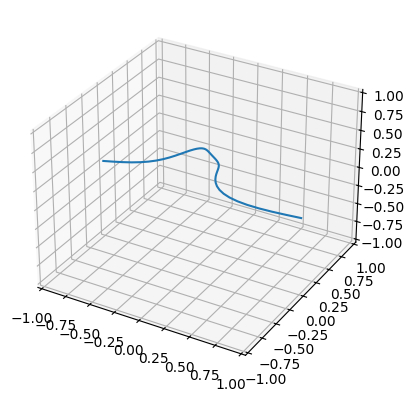

In [600]:
tangled_pts = generate()
ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
# ax.scatter(*tangled_pts.T)
ax.plot(*tangled_pts.T)

In [638]:
def sample_bilinear(im, coords):
    # Get integer-valued coordinates surrounding each sample point
    bounds = np.array(im.shape[1::-1]).reshape(1, -1) - 1
    corner_floor = np.clip(np.floor(coords).astype(int), 0, bounds)
    corners = [corner_floor]
    displacements = np.array([1, 0]), np.array([0, 1]), np.array([1, 1])
    for d in displacements:
        corners.append(np.clip(corner_floor + d.reshape(1, -1), 0, bounds))
    corners = np.stack(corners, axis=1)
    
    # Use fractional parts of the sample point coordinates to calculate
    # multipliers for each corner (based on area of the quadrant opposite that corner)
    remain = np.mod(coords, 1)
    remain_comp = 1 - remain
    multipliers = np.stack([
        remain_comp[:, 0] * remain_comp[:, 1],
        remain[:, 0] * remain_comp[:, 1],
        remain_comp[:, 0] * remain[:, 1],
        remain[:, 0] * remain[:, 1],
    ], axis=1).reshape(corners.shape[:-1])
    res = np.sum(multipliers * im[corners[:, :, 1], corners[:, :, 0]], axis=1)
    return res

In [737]:
WIDTH = 640
HEIGHT = 480

CAMERA_POS = [[0,   0,   -1],
              [0.5, 0,   -1],
              [0,   0.5, -1]]
CAMERA_ROT = np.eye(3)
CAMERA_INT = np.array([[WIDTH,      0,  WIDTH / 2],
                       [    0, HEIGHT, HEIGHT / 2],
                       [    0,      0,          1]])

def project(points, pos, rot, intrinsic):
    local_pts = (points[..., None, :] - pos)
    local_pts = np.einsum('ij,...i', rot, local_pts)
    local_pts /= local_pts[..., 2:]
    local_pts = np.einsum('ij,...j', intrinsic, local_pts)
    return local_pts[..., :2]

def draw(points):
    canvas = np.ones((HEIGHT, WIDTH))
    points = points.astype(int)
    for i in range(len(points) - 1):
        rr, cc = skimage.draw.line(points[i][1], points[i][0], points[i+1][1], points[i+1][0])
        canvas[rr, cc] = 0
    dist = sp.ndimage.distance_transform_edt(canvas)
    grad_x = np.diff(dist, axis=1)
    grad_y = np.diff(dist, axis=0)
    return points, canvas, dist, grad_x, grad_y

def optimize(points, grad_x, grad_y, weights=1, steps=100):
    for s in range(steps):
        force = np.zeros_like(points)

        for c in range(3):
            grads_x = sample_bilinear(grad_x[c], points)
            grads_y = sample_bilinear(grad_y[c], points)
            grads = np.stack((grads_x, grads_y), axis=-1)
            force -= weights * grads

            diff = np.diff(points, axis=0)
            sqr_mag = np.sum(diff * diff, axis=-1, keepdims=True)
            diff = diff / sqr_mag
            
            force[:len(diff)] += diff
            force[1:] -= diff

        points = points + force

        points += np.random.normal(0, 10 / (s + 1), points.shape)
        points = np.clip(points, np.zeros(2), np.array((WIDTH, HEIGHT)))
    return points

In [746]:
points_2d = project(tangled_pts, CAMERA_POS, CAMERA_ROT)

print(points_2d.shape)

points_img, img, dist, grad_x, grad_y = zip(*[draw(points_2d[:, i]) for i in range(3)])

starting_points = np.stack((np.linspace(0, 639, 100), np.zeros(100), np.zeros(100)), axis=-1)

weights = np.full((100, 1), 1)
weights[0] = 0
weights[-1] = 0

optimized = optimize(starting_points, grad_x, grad_y, weights)

plt.plot(*optimized.T, color='blue')
plt.scatter(*points_img.T, color='red')

(50, 3, 2)


AttributeError: 'tuple' object has no attribute 'shape'